### `Setup`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:63: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you m

#### `Config`

In [2]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

### `Data Augmentation`

In [23]:
img_size_L = (168, 224)
img_size_M = (93, 124)
img_size_S = (48, 64)

# IMG Transformations
augmentations = {
    'train': v2.Compose([
    # v2.Grayscale(1),
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(img_size_M, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val+test': v2.Compose([
    # v2.Grayscale(1),
    v2.Resize(img_size_M, antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [5]:
# Normal Dataset
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=augmentations['train'], 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=augmentations['val+test'], 
                            split='val', 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val+test'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 15646
Lenght of val data: 3345
Lenght of val data: 3433


In [6]:
train_data.metadata.target.value_counts(True)

safe driving                    0.113511
talking on the phone - left     0.103924
texting - left                  0.103349
talking on the phone - right    0.102582
drinking                        0.102582
operating the radio             0.102263
texting - right                 0.101815
talking to passenger            0.092931
reaching behind                 0.092356
hair and makeup                 0.084686
Name: target, dtype: float64

In [7]:
val_data.img_labels.classname.value_counts(True)

c0    0.110314
c3    0.107025
c6    0.102840
c9    0.101943
c4    0.100448
c2    0.100149
c5    0.100149
c1    0.098954
c8    0.092975
c7    0.085202
Name: classname, dtype: float64

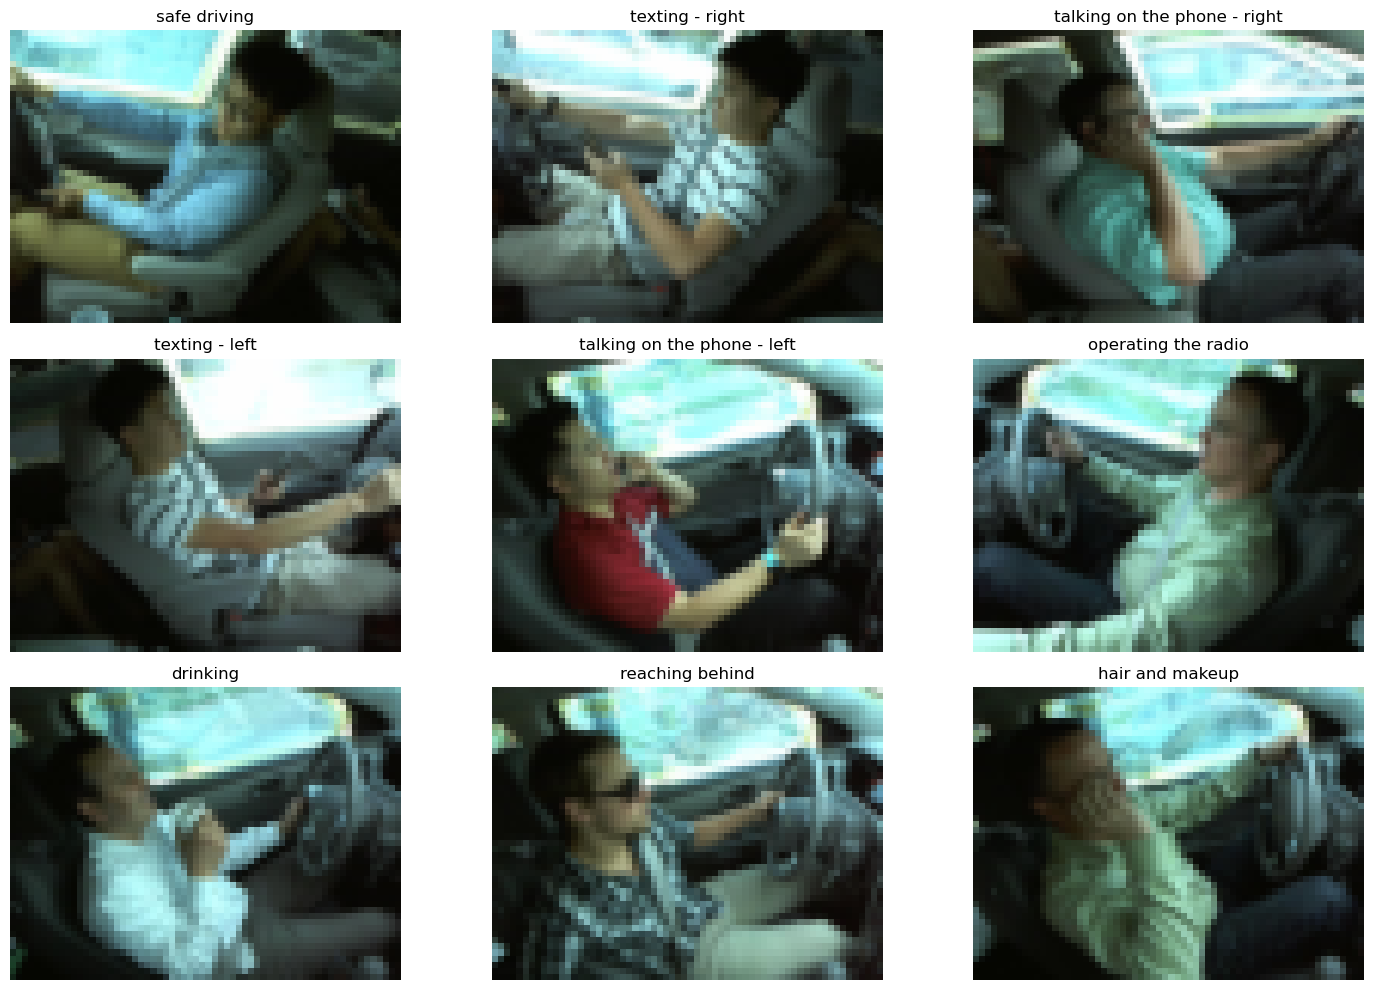

In [8]:
# Displaying training data including transformations
train.display_classes(id_to_class=True)

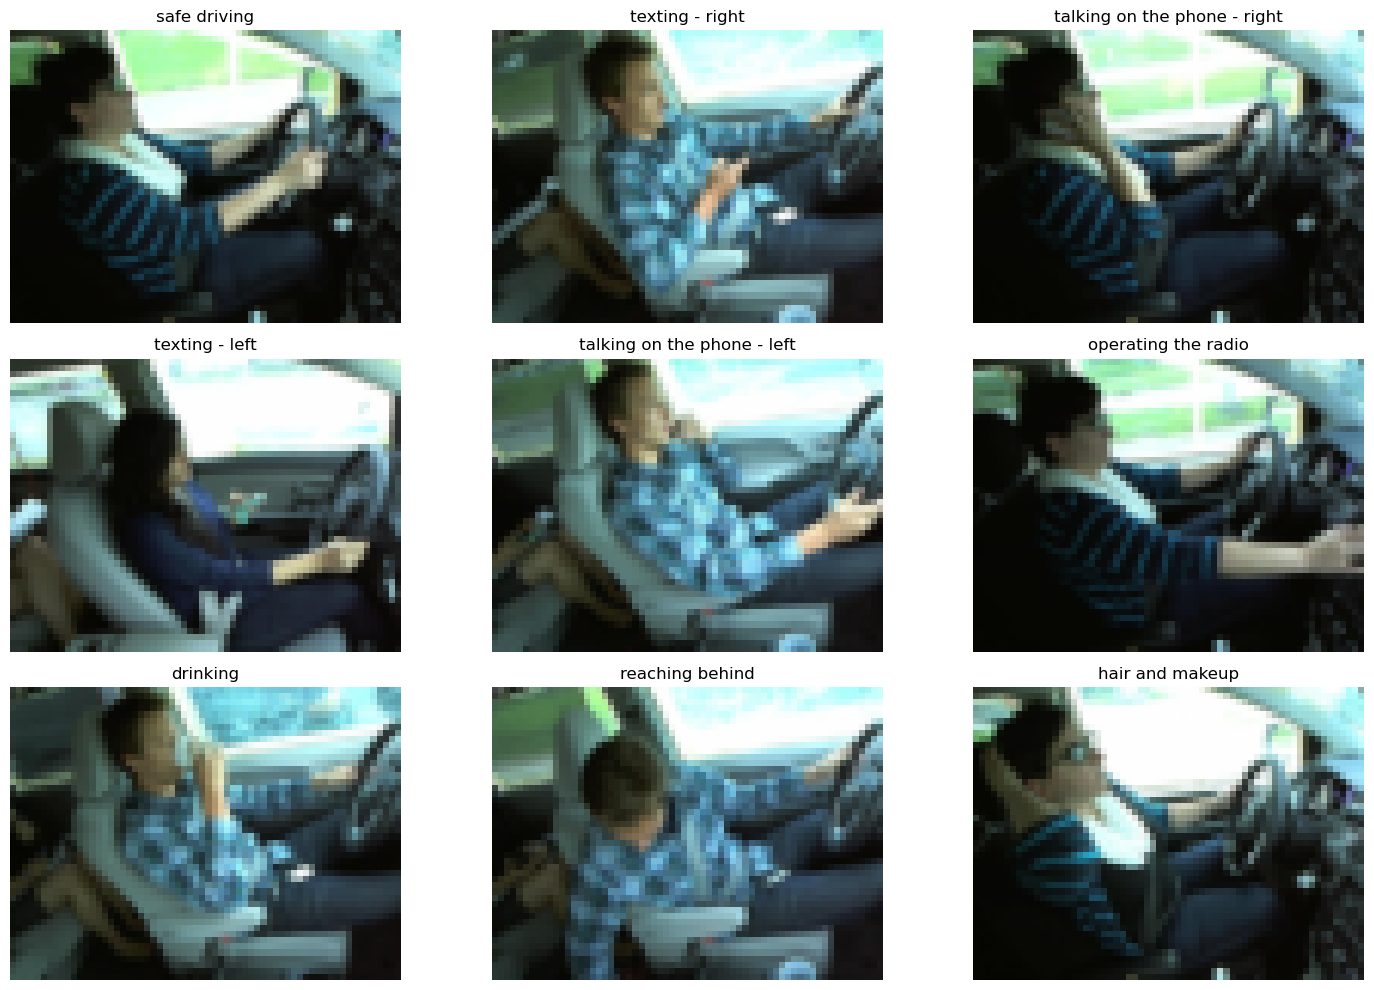

In [9]:
# Displaying val data including transformations
val_data.display_classes(id_to_class=True)

## `Model`

In [10]:
def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=1000):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 1280)

        self.classifier = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 1280)
        x = self.classifier(x)
        return x

In [12]:
# Initialize MobileNet model
model = MobileNetV2(n_classes = 10)

In [13]:
batch_size = 32
epochs = 50
seed = 42

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [15]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV2                                   [32, 10]                  --
├─Sequential: 1-1                             [32, 32, 24, 32]          --
│    └─Conv2d: 2-1                            [32, 32, 24, 32]          864
│    └─BatchNorm2d: 2-2                       [32, 32, 24, 32]          64
│    └─ReLU6: 2-3                             [32, 32, 24, 32]          --
├─Sequential: 1-2                             [32, 320, 2, 2]           --
│    └─InvertedBlock: 2-4                     [32, 16, 24, 32]          --
│    │    └─Sequential: 3-1                   [32, 16, 24, 32]          896
│    └─InvertedBlock: 2-5                     [32, 24, 12, 16]          --
│    │    └─Sequential: 3-2                   [32, 24, 12, 16]          5,136
│    └─InvertedBlock: 2-6                     [32, 24, 12, 16]          --
│    │    └─Sequential: 3-3                   [32, 24, 12, 16]          8,832
│    └─Inver

## `Training Methods`

##### `Helpers`

In [16]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [17]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [18]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

#### `Train and val step`

In [19]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [20]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

#### `Train loop`

In [24]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, model_name, epoch)
            visualize_training(history, epoch+1)
            break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history

## `Model Training`


Epoch 1 of 50 started...
Epoch 1 of 50 (1:6) - Train loss: 2.20140 - Train acc: 0.20449 - Val loss: 2.04944 - Val acc: 0.30514
Saving model with new best val_loss: 2.04944

Epoch 2 of 50 started...
Epoch 2 of 50 (1:8) - Train loss: 1.59452 - Train acc: 0.42542 - Val loss: 1.73767 - Val acc: 0.37857
Saving model with new best val_loss: 1.73767

Epoch 3 of 50 started...
Epoch 3 of 50 (1:6) - Train loss: 1.20702 - Train acc: 0.57243 - Val loss: 2.10826 - Val acc: 0.35455
Early Stopping Counter 1 of 6

Epoch 4 of 50 started...
Epoch 4 of 50 (1:7) - Train loss: 1.01270 - Train acc: 0.65455 - Val loss: 1.42020 - Val acc: 0.51511
Saving model with new best val_loss: 1.42020
Early Stopping Counter Reset

Epoch 5 of 50 started...
Epoch 5 of 50 (1:6) - Train loss: 0.92878 - Train acc: 0.67991 - Val loss: 1.75672 - Val acc: 0.49891


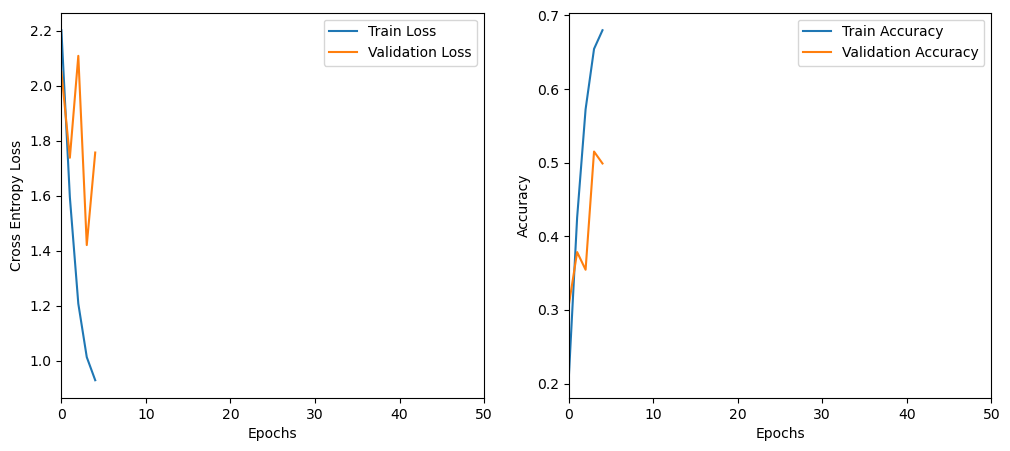

Early Stopping Counter 1 of 6

Epoch 6 of 50 started...
Epoch 6 of 50 (1:5) - Train loss: 0.85288 - Train acc: 0.71016 - Val loss: 1.63056 - Val acc: 0.51884
Early Stopping Counter 2 of 6

Epoch 7 of 50 started...
Epoch 7 of 50 (1:6) - Train loss: 0.81883 - Train acc: 0.72287 - Val loss: 1.51654 - Val acc: 0.47592
Early Stopping Counter 3 of 6

Epoch 8 of 50 started...
Epoch 8 of 50 (1:6) - Train loss: 0.79420 - Train acc: 0.73290 - Val loss: 1.78300 - Val acc: 0.42281
Early Stopping Counter 4 of 6

Epoch 9 of 50 started...
Epoch 9 of 50 (1:8) - Train loss: 0.76830 - Train acc: 0.74460 - Val loss: 1.67139 - Val acc: 0.44727
Early Stopping Counter 5 of 6

Epoch 10 of 50 started...
Epoch 10 of 50 (1:7) - Train loss: 0.74224 - Train acc: 0.75637 - Val loss: 1.94359 - Val acc: 0.41792


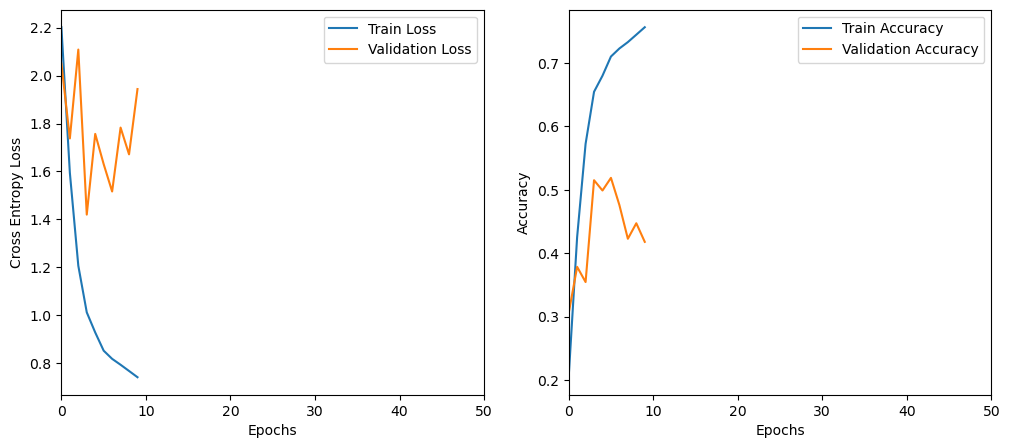

Early Stopping Counter 6 of 6
Epoch 10 of 50 - Early stopping
Saving final model, with loss:  1.9435942625557934


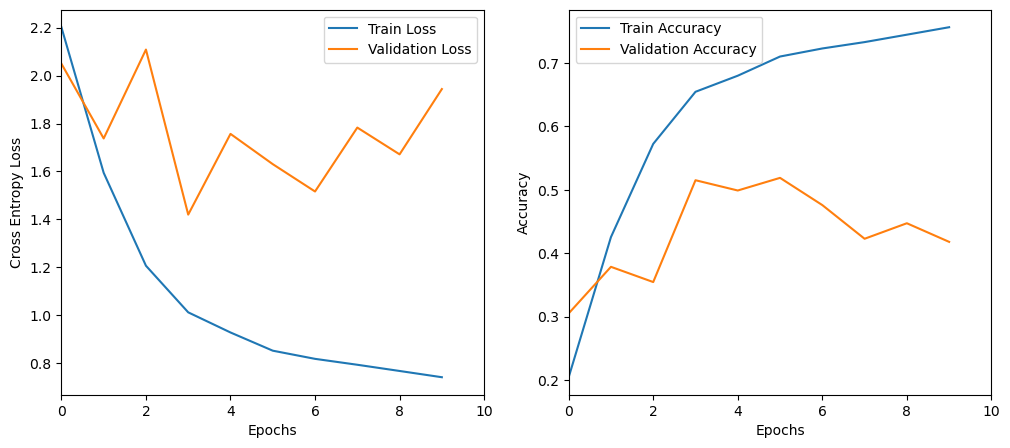

Total training time: 11:7


In [290]:
# Setting seed and general training setup
seed = 42
torch.manual_seed(seed)
epochs = 50
learming_rate = 0.001
momentum = .90
weight_decay = 1e-4
MODEL_NAME = 'TinyVGG_XSmall'
nestrov = False

# Creating Model Object
model = VGG_XSmall(num_classes = 10).to(device)

# Optimizer and scheduler
optimizer = torch.optim.RMSprop(model.parameters(), lr=learming_rate, weight_decay=weight_decay, momentum=momentum)


# Loss function
loss_fn = nn.CrossEntropyLoss()

# Early stopping
early_stopping = EarlyStopper(patience=6, min_delta=.03)

# results
vgg_xsmall_results = train(model=model,
                           train_dataloader=train_dataloader,
                           validation_dataloader=test_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=epochs,
                           device=device,
                           scheduler=None,
                           early_stopping=early_stopping,
                           model_name=MODEL_NAME)

##### `Medium resized images`


Epoch 1 of 50 started...
Epoch 1 of 50 (3:50) - Train loss: 2.22720 - Train acc: 0.19163 - Val loss: 4.09080 - Val acc: 0.10175
Saving model with new best val_loss: 4.09080

Epoch 2 of 50 started...
Epoch 2 of 50 (3:49) - Train loss: 1.63888 - Train acc: 0.41175 - Val loss: 1.99256 - Val acc: 0.23297
Saving model with new best val_loss: 1.99256

Epoch 3 of 50 started...
Epoch 3 of 50 (3:54) - Train loss: 1.32154 - Train acc: 0.53010 - Val loss: 1.95741 - Val acc: 0.30786
Saving model with new best val_loss: 1.95741

Epoch 4 of 50 started...
Epoch 4 of 50 (3:59) - Train loss: 1.15695 - Train acc: 0.59257 - Val loss: 1.72194 - Val acc: 0.38967
Saving model with new best val_loss: 1.72194

Epoch 5 of 50 started...
Epoch 5 of 50 (3:45) - Train loss: 1.06681 - Train acc: 0.63078 - Val loss: 1.74705 - Val acc: 0.38514


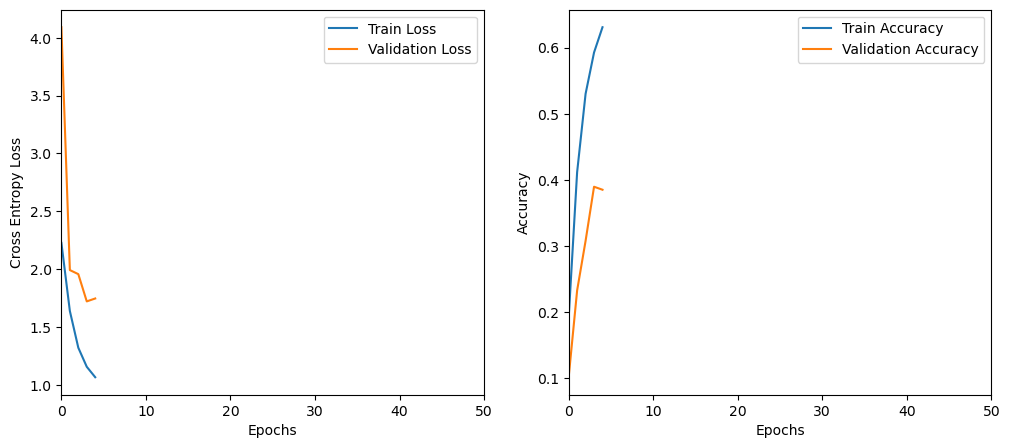


Epoch 6 of 50 started...
Epoch 6 of 50 (3:46) - Train loss: 0.99865 - Train acc: 0.65135 - Val loss: 1.63162 - Val acc: 0.46516
Saving model with new best val_loss: 1.63162

Epoch 7 of 50 started...
Epoch 7 of 50 (3:44) - Train loss: 0.94764 - Train acc: 0.67270 - Val loss: 1.76888 - Val acc: 0.39757
Early Stopping Counter 1 of 5

Epoch 8 of 50 started...
Epoch 8 of 50 (3:46) - Train loss: 0.91871 - Train acc: 0.68593 - Val loss: 1.51180 - Val acc: 0.47885
Saving model with new best val_loss: 1.51180
Early Stopping Counter Reset

Epoch 9 of 50 started...
Epoch 9 of 50 (3:44) - Train loss: 0.87754 - Train acc: 0.70389 - Val loss: 1.58194 - Val acc: 0.46549
Early Stopping Counter 1 of 5

Epoch 10 of 50 started...
Epoch 10 of 50 (3:42) - Train loss: 0.85671 - Train acc: 0.71174 - Val loss: 1.49232 - Val acc: 0.51672
Saving model with new best val_loss: 1.49232


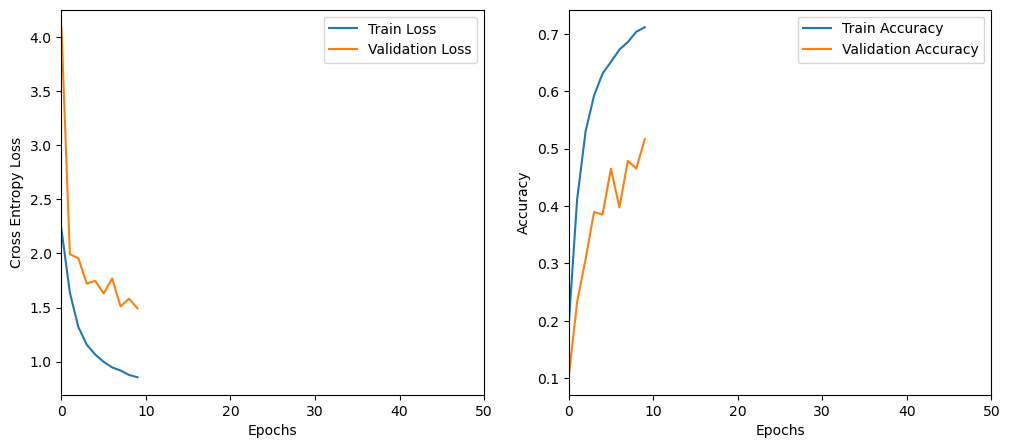

Early Stopping Counter Reset

Epoch 11 of 50 started...
Epoch 11 of 50 (3:42) - Train loss: 0.84375 - Train acc: 0.71647 - Val loss: 1.22374 - Val acc: 0.47743
Saving model with new best val_loss: 1.22374

Epoch 12 of 50 started...
Epoch 12 of 50 (3:42) - Train loss: 0.82486 - Train acc: 0.72285 - Val loss: 1.12302 - Val acc: 0.58529
Saving model with new best val_loss: 1.12302

Epoch 13 of 50 started...
Epoch 13 of 50 (3:40) - Train loss: 0.81606 - Train acc: 0.72657 - Val loss: 1.09958 - Val acc: 0.58298
Saving model with new best val_loss: 1.09958

Epoch 14 of 50 started...
Epoch 14 of 50 (3:43) - Train loss: 0.80520 - Train acc: 0.73035 - Val loss: 1.09374 - Val acc: 0.60047
Saving model with new best val_loss: 1.09374

Epoch 15 of 50 started...
Epoch 15 of 50 (3:43) - Train loss: 0.78675 - Train acc: 0.73458 - Val loss: 1.27799 - Val acc: 0.52484


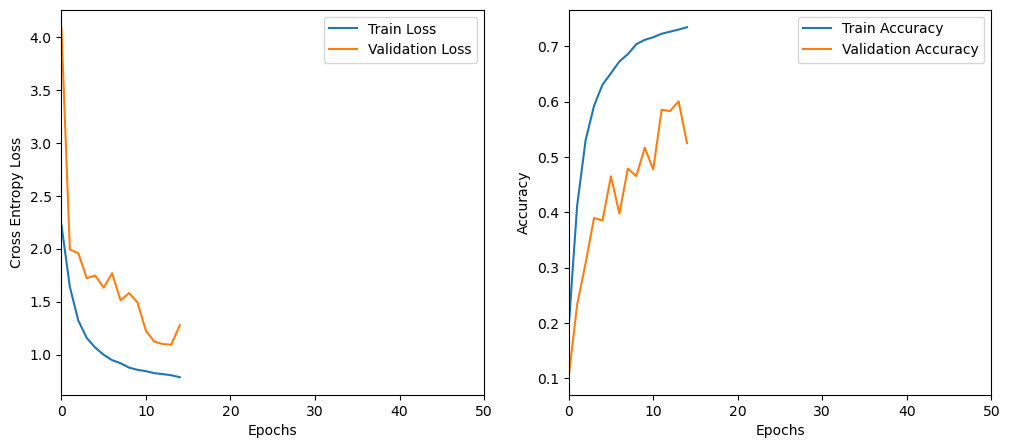

Early Stopping Counter 1 of 5

Epoch 16 of 50 started...
Epoch 16 of 50 (3:43) - Train loss: 0.78716 - Train acc: 0.73532 - Val loss: 1.30265 - Val acc: 0.54310
Early Stopping Counter 2 of 5

Epoch 17 of 50 started...
Epoch 17 of 50 (3:48) - Train loss: 0.76851 - Train acc: 0.74152 - Val loss: 1.31511 - Val acc: 0.59035
Early Stopping Counter 3 of 5

Epoch 18 of 50 started...
Epoch 18 of 50 (3:41) - Train loss: 0.77761 - Train acc: 0.73758 - Val loss: 1.78858 - Val acc: 0.44697
Early Stopping Counter 4 of 5

Epoch 19 of 50 started...
Epoch 19 of 50 (3:34) - Train loss: 0.75553 - Train acc: 0.74389 - Val loss: 1.19784 - Val acc: 0.59303
Early Stopping Counter 5 of 5
Epoch 19 of 50 - Early stopping
Saving final model, with loss:  1.197842810835157


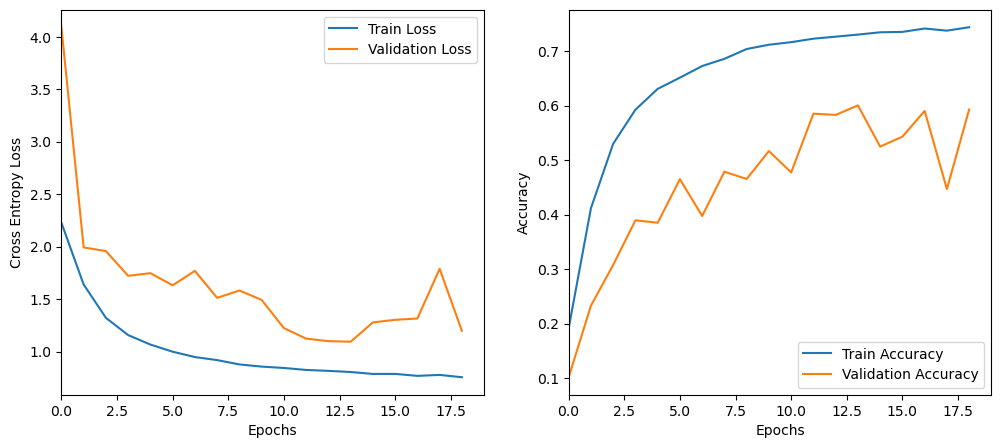

Total training time: 71:15


In [148]:
# Setting seed and general training setup
seed = 42
torch.manual_seed(seed)
epochs = 50
learming_rate = 0.001
momentum = .90
weight_decay = 1e-4
MODEL_NAME = 'TinyVGG_XSmall'
nestrov = False

# Creating Model Object
model = VGG_XSmall(num_classes = 10).to(device)
torch.optim.RMSprop
# Optimizer and scheduler
optimizer = torch.optim.RMSprop(model.parameters(), lr=learming_rate, weight_decay=weight_decay, momentum=momentum) # torch.optim.SGD(model.parameters(), lr=learming_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nestrov)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
#                                                        T_max = epochs,  
#                                                        eta_min = 0,
#                                                        verbose=1)
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Early stopping
early_stopping = EarlyStopper(patience=5, min_delta=.03)

# results
vgg_xsmall_results = train(model=model,
                           train_dataloader=train_dataloader,
                           validation_dataloader=val_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=epochs,
                           device=device,
                           scheduler=None,
                           early_stopping=early_stopping,
                           model_name=MODEL_NAME)

### Testing on Test Images

In [32]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

test_imgs = os.listdir(config['dataset']['images']['test'])
test_img = test_imgs[random.randint(0, len(test_imgs))]

In [452]:
def test(model, dataloader, device):
    """Test loop"""
    # Setup test accuracy
    test_acc = 0
    
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Accuracy {test_acc / len(dataloader)}')
    return images, classes, predictions, predictions_argmax

In [453]:
test_predictions = test(model=model,
                        dataloader=test_dataloader,
                        device=device)

Test Accuracy 0.5665782759992444


In [ ]:
"2023-11-27 20:48:07 (Rasmus Krebs)\n-- 2023-11-27 20:46:20 (Rasmus Krebs) --\nThis is a report i guess"

In [158]:
test_images = test_predictions[0]
test_classess = test_predictions[1]
test_predictions = test_predictions[2]
test_predictions_argmax = test_predictions[3]

In [163]:
test_predictions_argmax[0]

tensor([ 3.6673, -1.7625, -0.0650,  0.8020,  0.6184,  2.6423, -1.4340,  1.1594,
         0.4719,  2.9084], device='mps:0')

Prediction: talking on the phone - left
True: talking on the phone - left


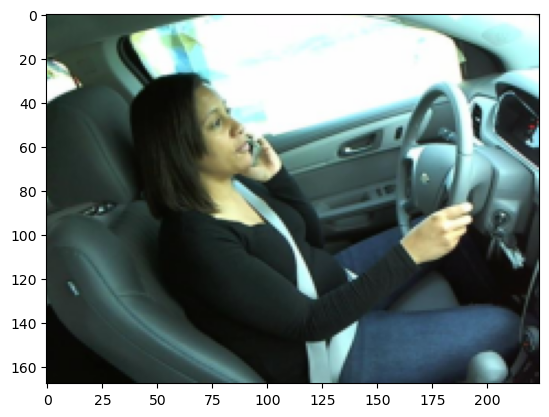

In [192]:
index = 16
print('Prediction:', config['dataset']['class_mapping']['c' + str(prediction.argmax(1)[index].item())])
print('True:', config['dataset']['class_mapping']['c' + str(labels[index].item())])

plt.imshow(imgs[index].cpu().permute(1, 2, 0))